In [293]:
import cPickle as pickle
import h5py
import sys
sys.path.append('/data/GCE_sys/')
import Analysis

# Load the DM profile flux for a gamma=1.25 
radius_, flux_ = pickle.load(open('../DM_radial_profile_alph_1.25.pickle', 'rb'))

quadrants = [['E', -45, 45], ['N', 45, 135], ['W', 135, 225], ['S', 225, 315]]


A = Analysis.Analysis(nside=256)
npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
square_mask = A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2)

def GetQuadrant(model, quadrant):
    # Open the file and load the fit results of interest.
    h = h5py.File('../mod_c/mod_k_%i_XCO_stripped.hdf5'%model)
    fit = h['/fit_results/quadrants'].attrs
    avR = [.5*(r1+r2) for r1, r2 in fit['radius']]
    
    # Find closest energy.
    E = fit['energies']
    
    area_ratios = None
    
    for quad, start_angle, stop_angle in quadrants:
        if quad is not quadrant: 
            continue
        
        if area_ratios is None:
            # Calculate the ratio of each ring/quadrant to the total ROI in order to rescale the flux.
            area_ratios = [npix_roi/float(np.nonzero(A.GenRadialMask(r1,r2,plane_mask=2.,start_angle=start_angle, stop_angle=stop_angle)
                                                     *square_mask)[0].shape[0]) for r1, r2 in fit['radius']]
        
        # Read out the flux of each radial bin
        radial_prof = np.array([area_ratios[i_r]*E**2/1e3*fit['flux_ring_%i'%i_r+'_'+quad] for i_r in range(len(avR))])
        radial_prof_unc = np.array([area_ratios[i_r]*E**2/1e3*fit['fluxunc_ring_%i'%i_r+'_'+quad][:,1] for i_r in range(len(avR))])
    return avR, radial_prof, radial_prof_unc, E/1e3
        
        



In [294]:

def GetAllQuadrants(start, stop):
    '''
    returns a list [E,N,W,S] where E contains a list of [radius, flux, fluxunc] for each model.
    '''
    
    E = [GetQuadrant(i,'E') for i in range(start,stop)]
    N = [GetQuadrant(i,'N') for i in range(start,stop)]
    W = [GetQuadrant(i,'W') for i in range(start,stop)]
    S = [GetQuadrant(i,'S') for i in range(start,stop)]
    return E, N, W, S

E, N, W, S = GetAllQuadrants(0, 11)
E_gal, N_gal, W_gal, S_gal = GetAllQuadrants(43, 54)

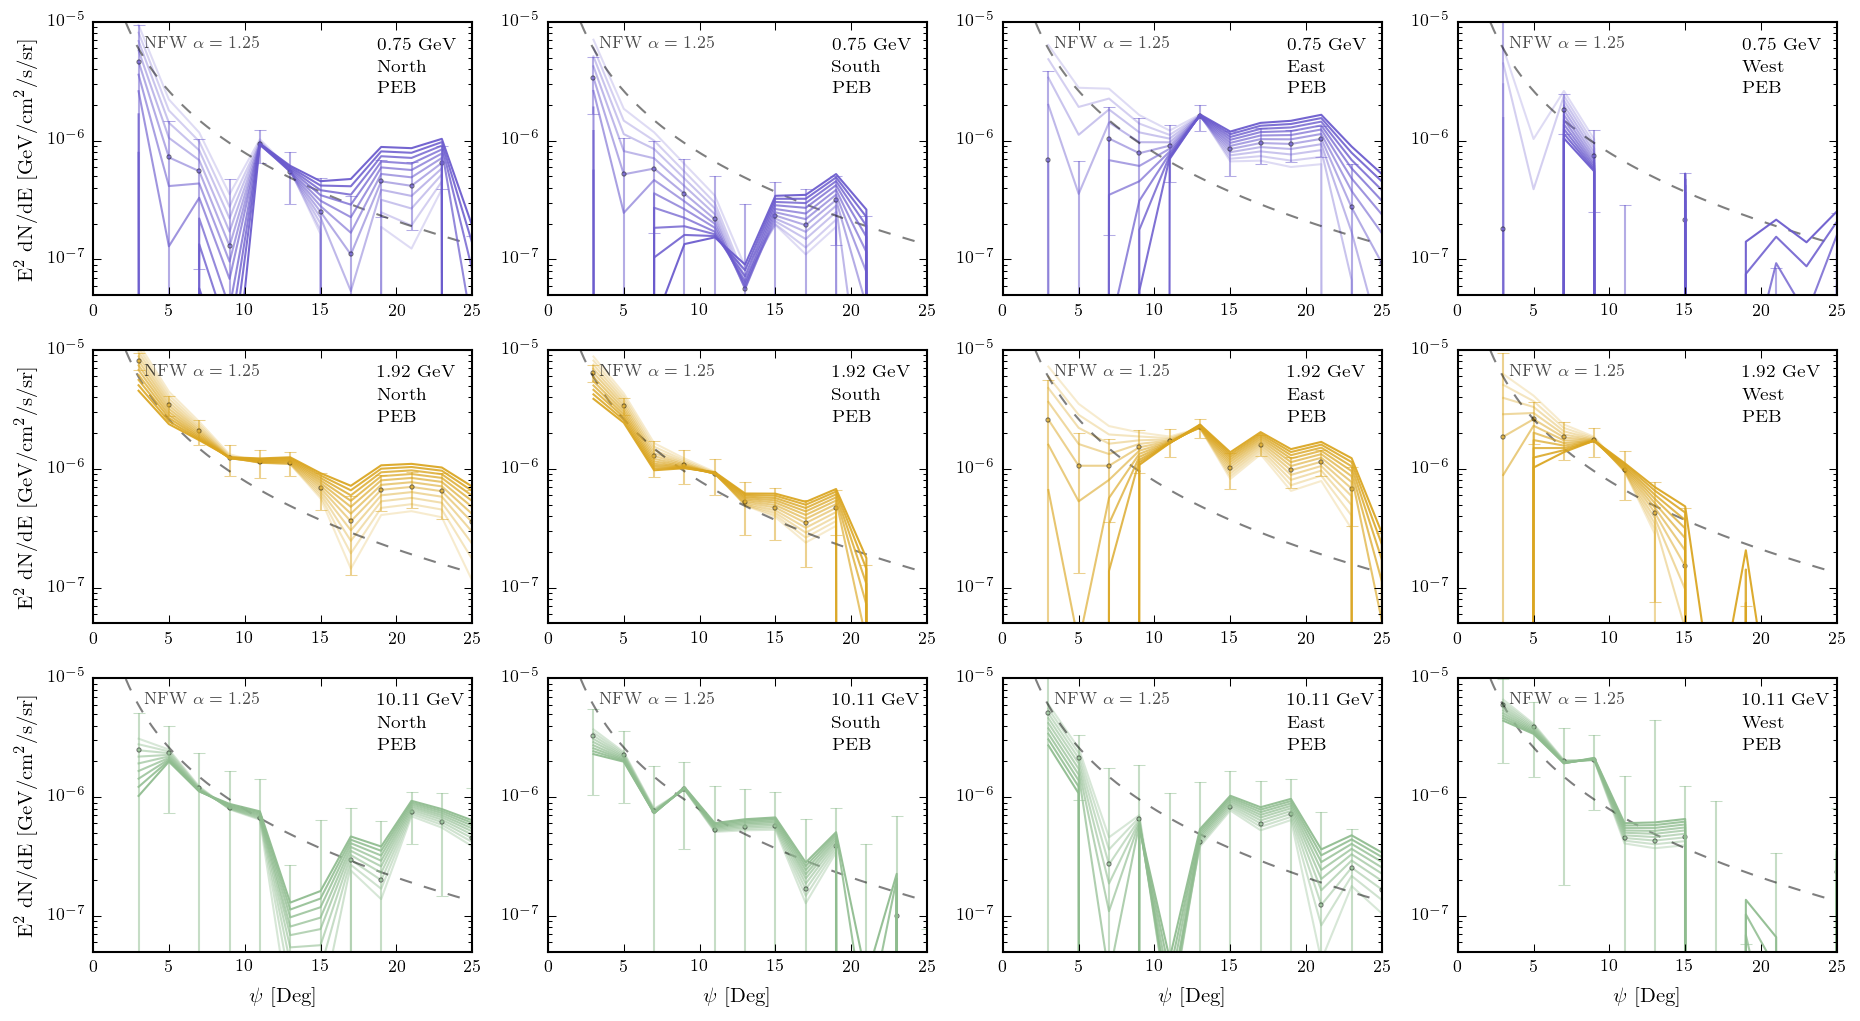

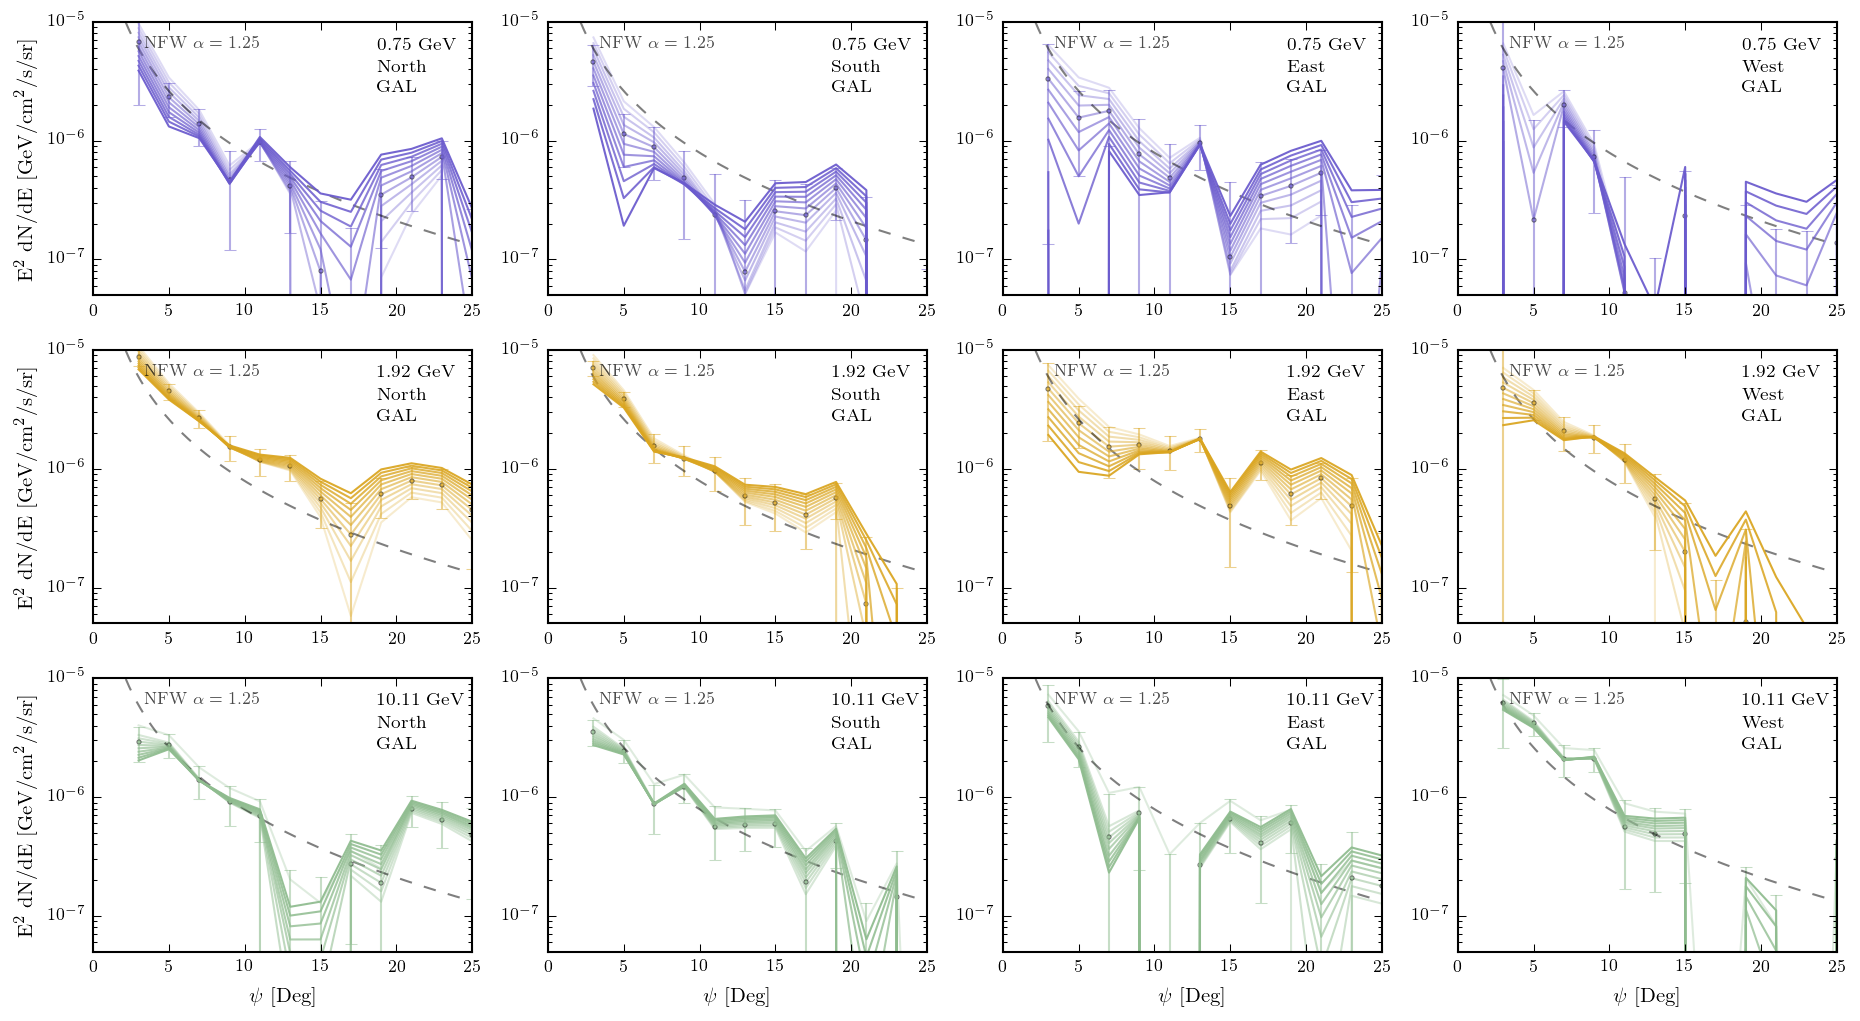

In [330]:
radius_, flux_ = pickle.load(open('../DM_radial_profile_alph_1.25.pickle', 'rb'))

def PlotQuadRadial(name, quad, energy, color , text2=''):
    for i_model, model in enumerate(quad): 
        #print np.array(model[1])[:,10].shape
        
        E_bin = np.argmin(np.abs(energy-model[3]))
        if i_model==4:
            plt.errorbar(model[0], model[1][:,E_bin], yerr=model[2][:,E_bin],color=color, alpha=(i_model+3)/14., marker='o', markersize=2)
            plt.plot(radius_, flux_*2.5e-30, color='k',alpha=.5,ls='--')
            plt.text(radius_[27],flux_[25]*2.7e-30 ,r'NFW $\alpha=1.25$',color='k',fontsize=8, alpha=.7)
        else: 
            plt.plot(model[0], model[1][:,E_bin], color=color, alpha=(i_model+3)/14.)
    plt.yscale('log')
    plt.text(.75,.9, '%1.2f GeV'%model[3][E_bin], transform=plt.gca().transAxes, fontsize=9)
    plt.text(.75,.82, name, transform=plt.gca().transAxes, fontsize=9)
    plt.text(.75,.74, text2, transform=plt.gca().transAxes, fontsize=9)
    if 'North' in name:
        plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
    if 10==energy:
        plt.xlabel(r'$\rm{\psi\ [Deg]}$')
    plt.xlim(0,25)
    plt.ylim(5e-8,1e-5)
    
quads = [['North',N],['South',S],['East',E],['West',W]]
plt.figure(figsize=(15,8))
for sp in range(1,5):
    plt.subplot(3,4,sp)
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], .75, color='slateblue', text2='PEB')
    plt.subplot(3,4,sp+4)
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], 2., color='goldenrod', text2='PEB' )
    plt.subplot(3,4,sp+8, )
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], 10., color='darkseagreen', text2='PEB')
plt.show()

quads = [['North',N_gal],['South',S_gal],['East',E_gal],['West',W_gal]]
plt.figure(figsize=(15,8))
for sp in range(1,5):
    plt.subplot(3,4,sp)
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], .75, color='slateblue', text2='GAL')
    plt.subplot(3,4,sp+4)
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], 2., color='goldenrod', text2='GAL' )
    plt.subplot(3,4,sp+8, )
    PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], 10., color='darkseagreen', text2='GAL')

/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide


[   0.32403703    0.37416574    0.42426407    0.47434165    0.52794469
    0.59025686    0.66383046    0.7514906     0.85699419    0.98542089
    1.14376798    1.34188       1.59394558    1.92099169    2.35520881
    2.94780954    3.78412469    5.01463055    6.92430739   10.10530554
   15.95329466   28.41814169   62.53072251  222.86451625] [  8.93147261e-07   2.70993672e-07   3.13564256e-07   2.96931143e-07
   4.14251888e-07   3.82349459e-07   7.11199960e-07   3.53767657e-07
   1.56274956e-06   1.31771541e-06   1.31600455e-06   1.29749143e-06
   1.63757913e-06   1.32626510e-06   8.20794254e-07   1.52364891e-06
   1.74591387e-06   1.54431585e-06   5.74182623e-07   0.00000000e+00
   4.88022617e-07   3.62878974e-07   4.87643716e-07   0.00000000e+00]


/home/carlson/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: RuntimeWarning: divide by zero encountered in divide


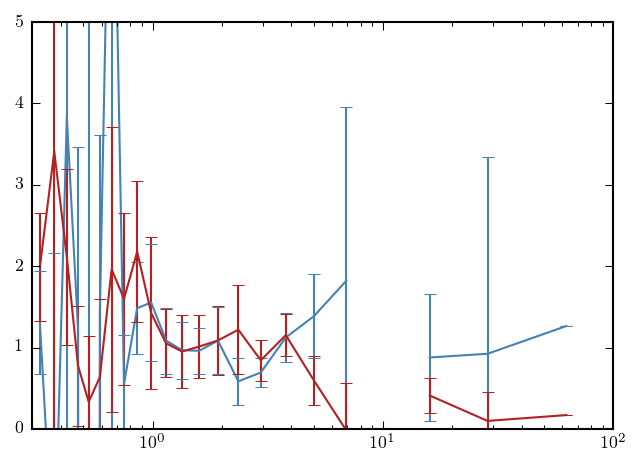

In [329]:

# quads = [['North',N],['West',W],['South',S],['East',E]]
# plt.figure(figsize=(15,8))
# for sp in range(1,5):
#     plt.subplot(3,4,sp)
#     PlotQuadRadial(quads[sp-1][0], quads[sp-1][1], .75, color='slateblue', text2='PEB')
#     plt.subplot(3,4,sp+4)



def GetQuadrantSpectrum(quads, quadrant, model_num, radius):
    r_list = np.array(quads[0][1][0][0])
    #print r_list
    r_bin = np.argmin(np.abs(r_list-radius))
    #print r_list[r_bin]
    for name, data in quads:
        if name == quadrant:
            # return E, flux, fluxunc
            return data[model_num][3], data[model_num][1][r_bin,:], data[model_num][2][r_bin,:]


def PlotQuadAsymmetry(number):
    t,f_N,fu_N = GetQuadrantSpectrum(quads, 'North', number, 9)
    t,f_S,fu_S = GetQuadrantSpectrum(quads, 'South', number, 9)
    t,f_E,fu_E = GetQuadrantSpectrum(quads, 'East', number, 9)
    t,f_W,fu_W = GetQuadrantSpectrum(quads, 'West', number, 9)
    print t, f_N
    plt.errorbar(t,f_N/f_S,np.sqrt( (fu_N/f_S)**2 + (f_N*fu_S/f_S**2)**2 ))
    plt.errorbar(t,f_E/f_W,np.sqrt( (fu_E/f_W)**2 + (f_E*fu_W/f_W**2)**2 ))
    
    plt.ylim(0,5)
    plt.xlim(3e-1, 1e2)
    plt.xscale('log')
PlotQuadAsymmetry(0)
    
    
    
#     for i_model, model in enumerate(quad): 
            
        
        
        
#         E_bin = np.argmin(np.abs(energy-model[3]))
#         if i_model==4:
#             plt.errorbar(model[0], model[1][:,E_bin], yerr=model[2][:,E_bin],color=color, alpha=(i_model+3)/14., marker='o', markersize=2)
#             plt.plot(radius_, flux_*2.5e-30, color='k',alpha=.5,ls='--')
#             #plt.text(radius_[27],flux_[25]*2.7e-30 ,r'NFW $\alpha=1.25$',color='k',fontsize=8, alpha=.7)
#         else: 
#             plt.plot(model[0], model[1][:,E_bin], color=color, alpha=(i_model+3)/14.)
#     plt.yscale('log')
#     plt.text(.75,.9, '%1.2f GeV'%model[3][E_bin], transform=plt.gca().transAxes, fontsize=9)
#     plt.text(.75,.82, name, transform=plt.gca().transAxes, fontsize=9)
#     plt.text(.75,.74, text2, transform=plt.gca().transAxes, fontsize=9)
#     if 'North' in name:
#         plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$')
#     if 10==energy:
#         plt.xlabel(r'$\rm{\psi\ [Deg]}$')
#     plt.xlim(0,25)
#     plt.ylim(5e-8,1e-5)
    
    
    
    
quads = [['North',N],['West',W],['South',S],['East',E]]



